<a href="https://colab.research.google.com/github/Veraeze/AmineRegeneration/blob/main/AmineDegradation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Step 1: Install Dependencies and Load Dataset**

In this step, we install the required Python libraries and load the same amine regeneration dataset used to train the model for predicting reboiler duty. The goal is to build a machine learning model to detect early signs of foaming, fouling, and amine degradation.


In [ ]:
#  Install dependencies

!pip install pandas matplotlib seaborn scikit-learn

In [ ]:
#  Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
#  Mount Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Load dataset

file_path = '/content/drive/MyDrive/MLDatasets/amine_gen_data.csv'
df = pd.read_csv(file_path, skiprows=[1, 2])


## **Step 2: Exploratory Data Analysis (EDA)** *italicised text*

In this step, we explore key features in the dataset that may help in detecting early signs of foaming, fouling, and amine degradation.

The goal of this EDA is to:

Visually inspect how important process variables (e.g., amine composition, temperatures, pressures, molar flows) behave across different cases.
Identify possible clusters or anomalies in the data,
Understand relationships or correlations between key features,
Support decisions on clustering strategy or label creation for predictive modeling.
EDA Focus Areas:

Gas Composition (CO₂, H₂S) —> as proxies for amine performance and potential foaming.
Temperatures (DEA6, DEA7) —> as indicators of thermal stress or degradation.
Pressures and Molar Flow —> to observe operational fluctuations that may signal fouling or flow restrictions.

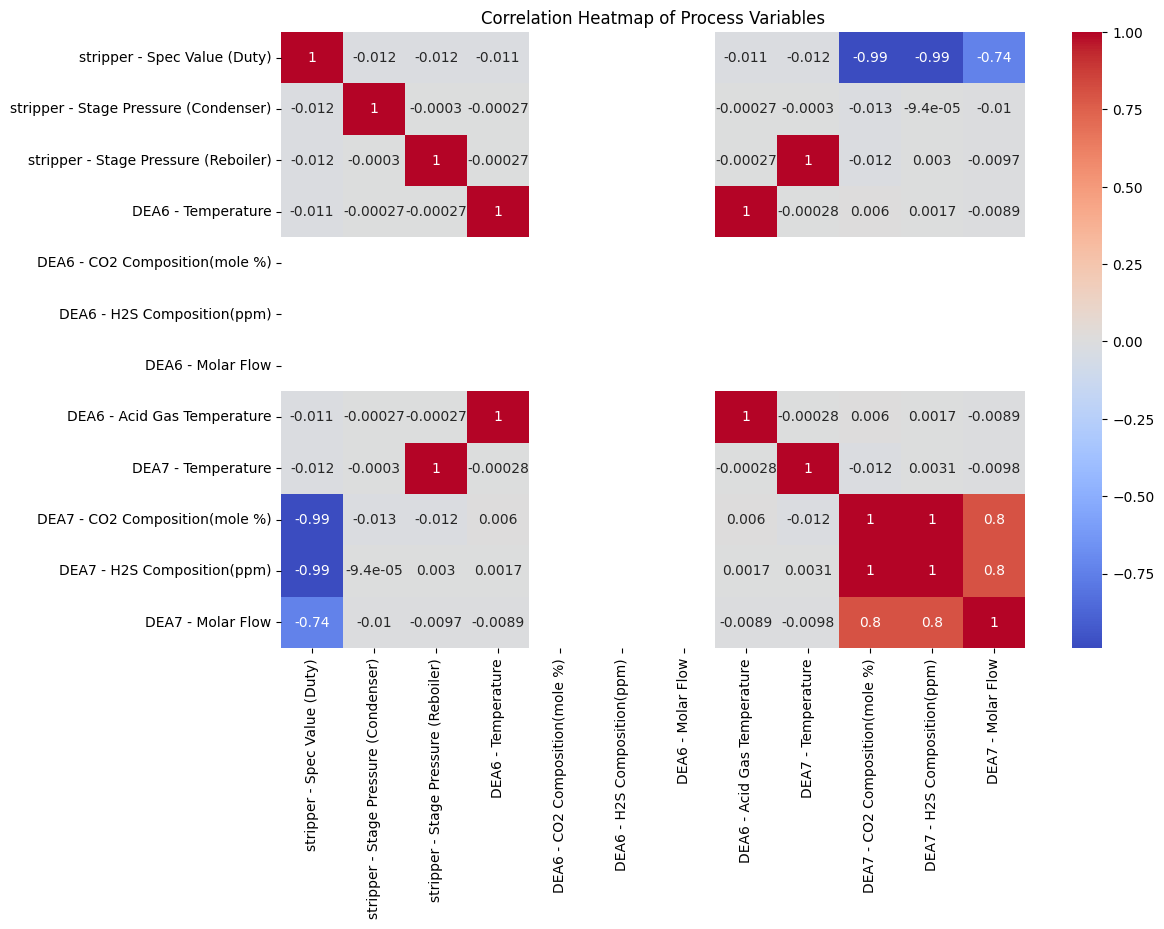

In [ ]:
# Correlation heatmap

df = df.drop(columns=['State'])

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Process Variables')
plt.show()

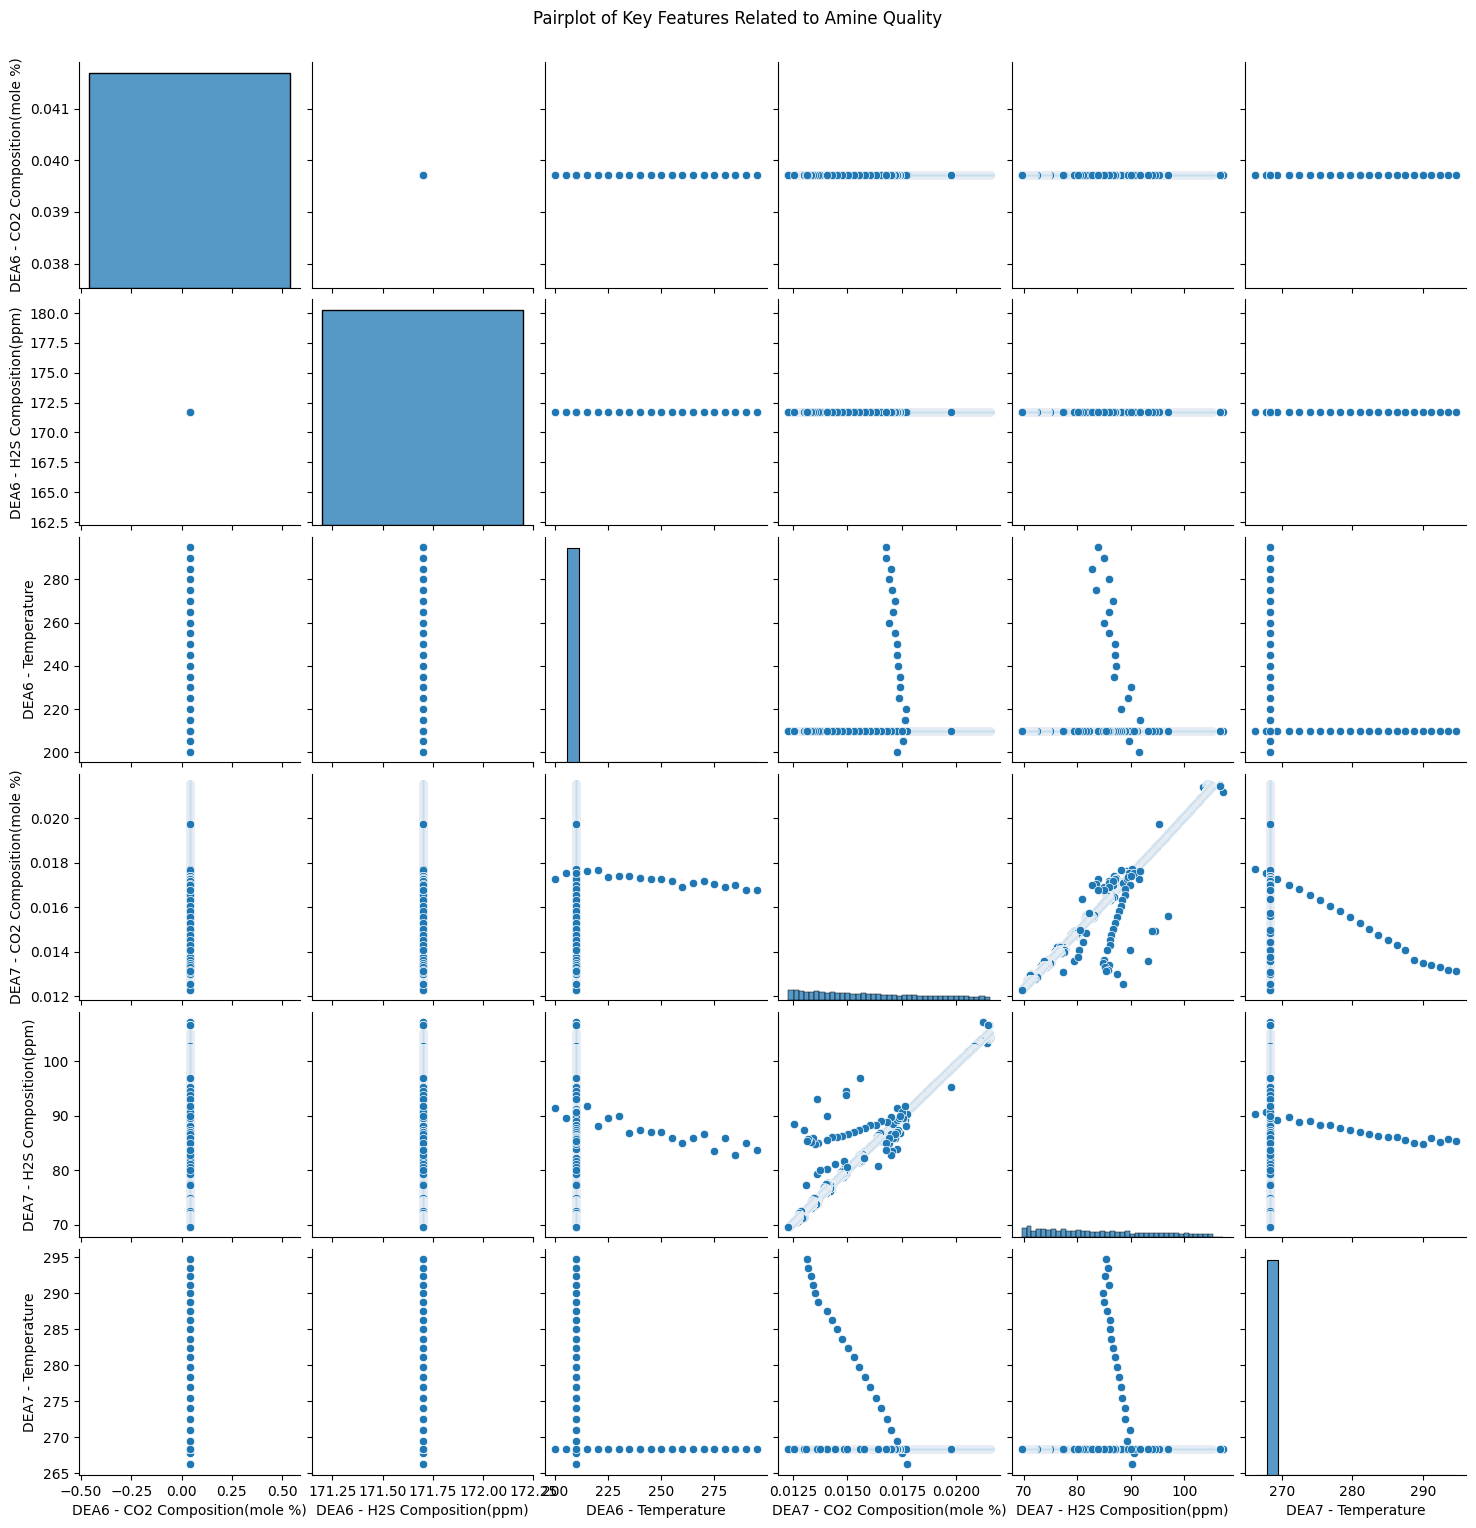

In [ ]:
# Pairplot of key gas composition & temperature features

cols_of_interest = [
    'DEA6 - CO2 Composition(mole %)',
    'DEA6 - H2S Composition(ppm)',
    'DEA6 - Temperature',
    'DEA7 - CO2 Composition(mole %)',
    'DEA7 - H2S Composition(ppm)',
    'DEA7 - Temperature'
]

sns.pairplot(df[cols_of_interest])
plt.suptitle('Pairplot of Key Features Related to Amine Quality', y=1.02)
plt.show()

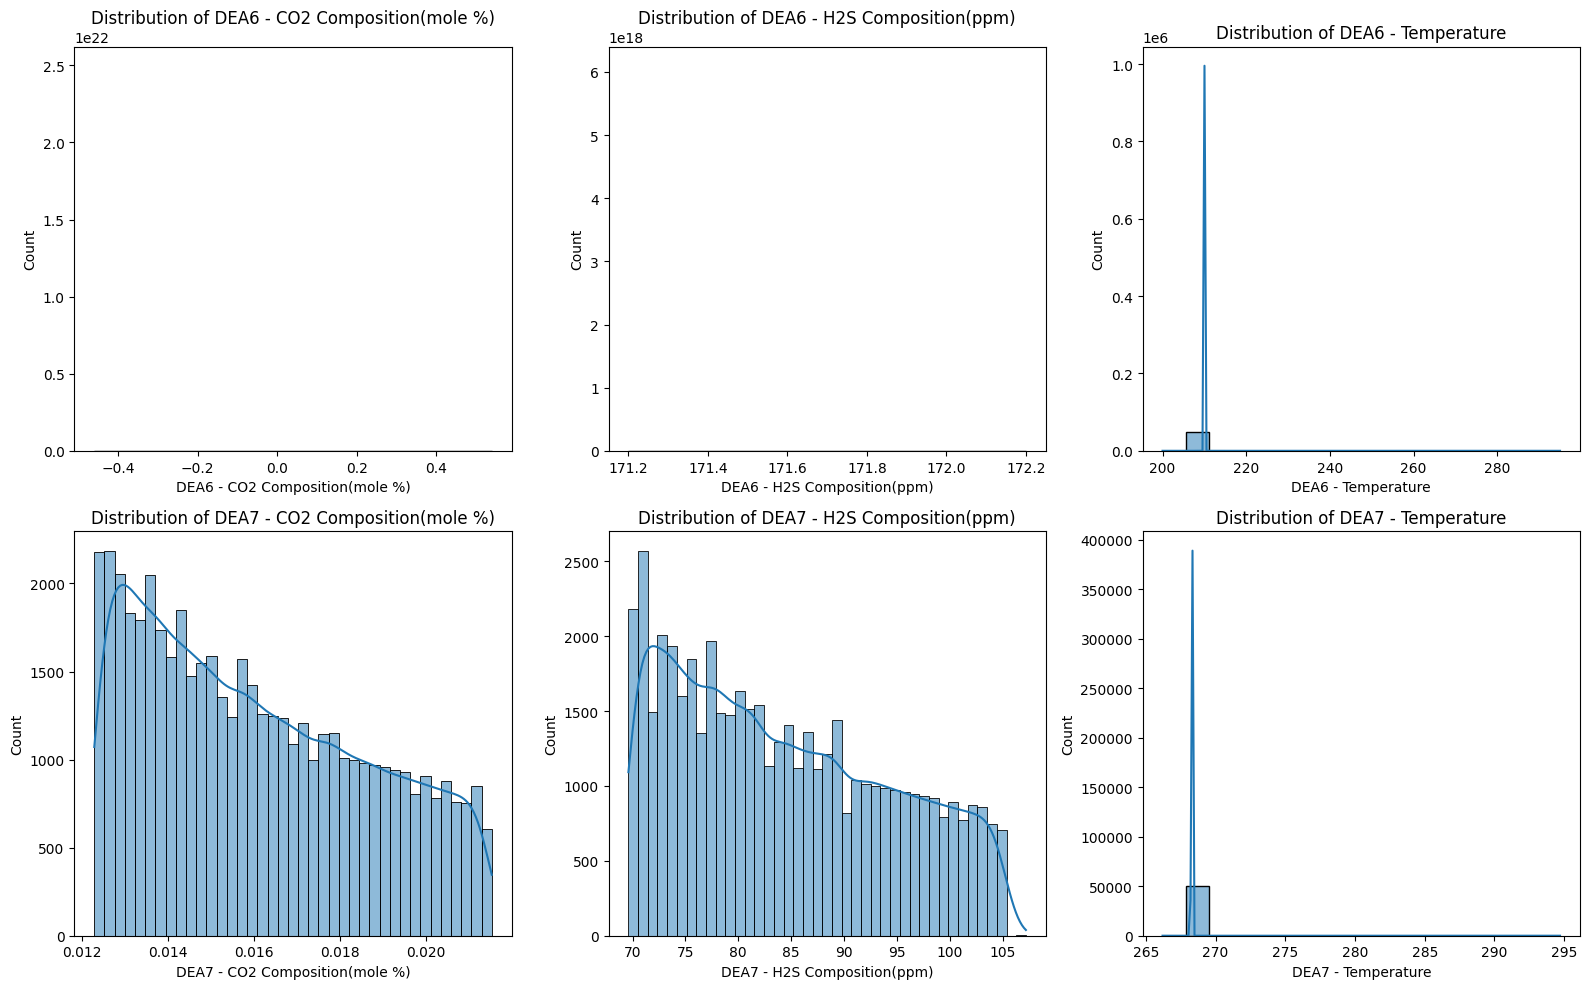

In [ ]:
# Distribution plots for possible degradation indicators

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(cols_of_interest):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

## **Step 3: Feature Engineering**
We create new features showing the difference between lean amine (DEA6) and rich amine (DEA7).

These deltas help us understand how much gas the amine absorbed and how much the system heated up.

New Features:

  - Delta_CO2 = DEA7 CO₂ − DEA6 CO₂
  - Delta_H2S = DEA7 H₂S − DEA6 H₂S
  - Delta_Temp = DEA7 Temp − DEA6 Temp
These will help us detect signs of degradation, fouling, and foaming more clearly.

In [ ]:
# CO2 and H2S deltas (gas absorption)

df['Delta_CO2'] = df['DEA7 - CO2 Composition(mole %)'] - df['DEA6 - CO2 Composition(mole %)']
df['Delta_H2S'] = df['DEA7 - H2S Composition(ppm)'] - df['DEA6 - H2S Composition(ppm)']

df['Delta_Temp'] = df['DEA7 - Temperature'] - df['DEA6 - Temperature']
df[['Delta_CO2', 'Delta_H2S', 'Delta_Temp']].describe()

,Delta_CO2,Delta_H2S,Delta_Temp
count,49915.000000,49915.000000,49915.000000
mean,-0.023663,-87.384606,58.290690
std,0.002608,10.133323,1.001506
min,-0.027430,-102.090000,-26.700000
25%,-0.025960,-96.280000,58.300000
50%,-0.024060,-88.860000,58.300000
75%,-0.021580,-79.240000,58.300000
max,-0.018190,-64.500000,84.700000


###  Delta Feature Summary

We calculated the following **delta features**:

| Feature        | Description                                 |
|----------------|---------------------------------------------|
| `Delta_CO2`    | Change in CO₂ composition (DEA7 - DEA6)     |
| `Delta_H2S`    | Change in H₂S composition (DEA7 - DEA6)     |
| `Delta_Temp`   | Temperature increase through the amine loop |

Key Observations:

  - Delta_CO2 and Delta_H2S are negative, indicating that DEA6 (lean amine) contains more acid gas than DEA7 (rich amine), which is unusual. This may suggest data inversion or sensor mislabeling.
  - Delta_Temp has a consistent positive mean (~58.3°C), showing stable heating during regeneration.
  - Minimal spread in Delta_Temp confirms controlled process operation, but high variability in gas deltas suggests possible fouling or amine degradation.
These features will help us cluster different operational health states in the next step.


## **Step 4: Clustering Based on Delta Features using Kmeans**

In this step, we apply KMeans Clustering using the engineered delta features. We don’t have labeled examples of “degraded” or “healthy” amine states. Clustering helps us group the data into patterns that may represent:

  - Healthy operation
  - Early degradation
  - Fouled / saturated amine

Features Used:

  - `Delta_CO2`
  - `Delta_H2S`
  - `Delta_Temp`

These represent changes between lean and rich amine in terms of gas absorption and temperature which are useful indicators of amine system performance.

In [ ]:
#  Import libraries

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
# Define delta features for clustering

delta_features = ['Delta_CO2', 'Delta_H2S', 'Delta_Temp']
X = df[delta_features]

In [ ]:
# Scale the features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply Kmeans clustering

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

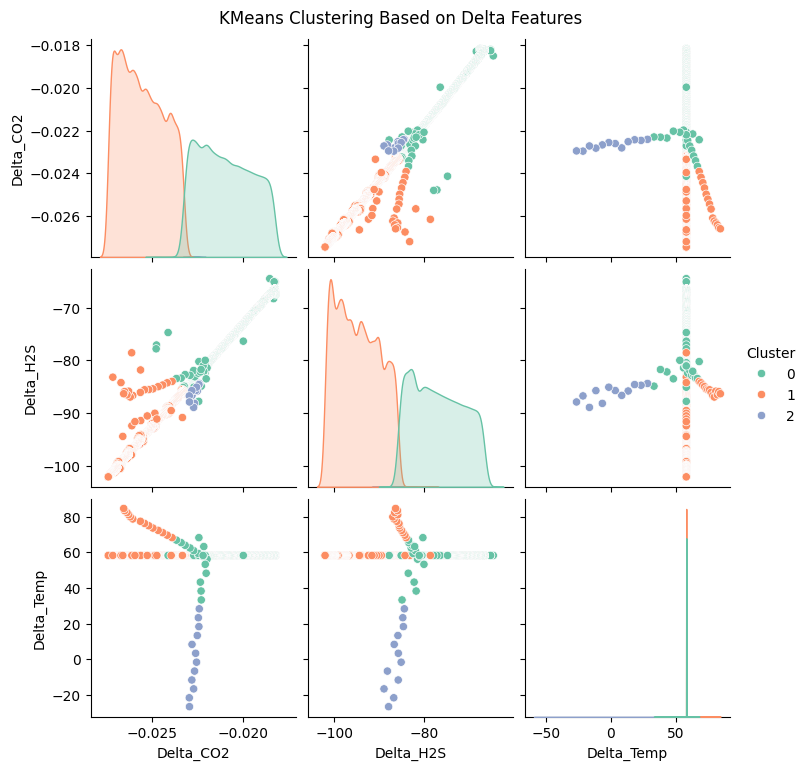

In [ ]:
# Pairplot to visualize clusters

sns.pairplot(df, vars=delta_features, hue='Cluster', palette='Set2')
plt.suptitle('KMeans Clustering Based on Delta Features', y=1.02)
plt.show()

/tmp/ipython-input-3452191497.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df, palette='Set2')


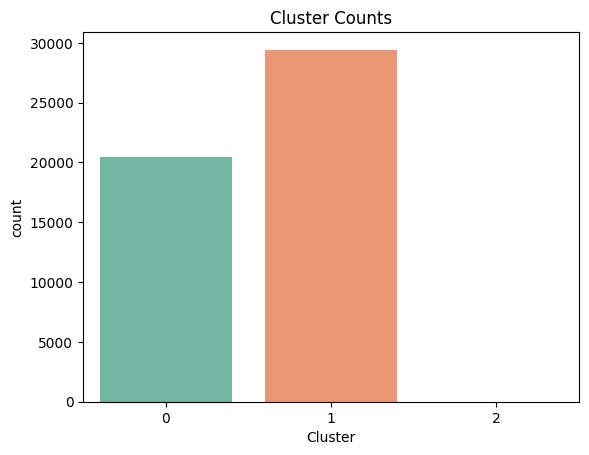

In [ ]:
# Cluster count plot

sns.countplot(x='Cluster', data=df, palette='Set2')
plt.title('Cluster Counts')
plt.show()

Based on the KMeans clustering using only delta features (`Delta_CO2`, `Delta_H2S`, `Delta_Temp`):

  - Cluster 0 (Green):

    - Lower Delta_CO2 and Delta_H2S, indicating minimal absorption of acid gases.
    - Relatively stable Delta_Temp.
    - This likely corresponds to Healthy Operation.
  - Cluster 1 (Orange):

    - Higher Delta_CO2 and Delta_H2S, suggesting increased acid gas loading.
    - Noticeable variation in Delta_Temp.
    - May represent Early Degradation or Transitioning State.
  - Cluster 2:

    - No data points assigned to Cluster 2 in this run.
    - This means the dataset separated cleanly into 2 main clusters.
Including delta features appears to have improved cluster separation related to amine loading and regeneration behavior.

## **Step 5: Assign Labels to Clusters for Classification**

In this step, we convert this unsupervised structure into a supervised classification task. The goal is to use cluster interpretations to assign meaningful class labels that represent the amine system health state.

Cluster-to-Label Mapping:

  - Cluster 0 → 'Healthy'
  - Cluster 1 → 'Early Degradation'
  - Cluster 2 → 'Fouled / Degraded'

These will become the target labels for our classification model.

In [ ]:
#  Define mapping

cluster_label_map = {
    0: 'Healthy',
    1: 'Early Degradation',
    2: "Unknown"
}

In [ ]:
# Create a new column in the dataframe with mapped labels

df['Health_State'] = df['Cluster'].map(cluster_label_map)
df["Health_State"].value_counts()

,count
Health_State,
Early Degradation,29422
Healthy,20481
Unknown,12


##  **Step 6: Train Classification Model**

In this step, we train a supervised classifier to predict amine health states using the labeled clusters from KMeans.

The goal is to classify each data point as:

- Healthy
- Early Degradation
- Fouled / Degraded

Features Used:

- DEA7 sensor data (CO₂, H₂S, Temp, Flow)
- Reboiler Duty
- Delta features (ΔCO₂, ΔH₂S, ΔTemp)

Model:

We use a Random Forest Classifier for its accuracy and feature importance insight. The trained model will support real-time monitoring of the amine system in the dashboard.

In [ ]:
# Import libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
# Feature selection and scaling

X = X_scaled
y = df['Health_State']

In [ ]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
# Train classifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions and evaluation
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
                    precision    recall  f1-score   support

Early Degradation       1.00      1.00      1.00      7356
          Healthy       1.00      1.00      1.00      5120
          Unknown       0.75      1.00      0.86         3

         accuracy                           1.00     12479
        macro avg       0.92      1.00      0.95     12479
     weighted avg       1.00      1.00      1.00     12479


Confusion Matrix:
 [[7356    0    0]
 [   2 5117    1]
 [   0    0    3]]


### Model Evaluation

The classification model trained on the KMeans-derived health states shows excellent performance:

- **Early Degradation**: Perfect detection (Precision 1.00, Recall 1.00).
- **Healthy**: Perfect detection except for 3 misclassified samples.
- **Unknown**: Small cluster of ambiguous states with slightly lower precision.

Interpretation:

- The model has learned to distinguish Healthy and Early Degradation states with very high confidence.
- The Unknown class had only 3 samples, leading to less robust metrics.

In [ ]:
import joblib

#  Export the trained model

joblib.dump(clf, 'amine_degradation.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import pickle

with open('amine_degradation.pkl', 'wb') as file:
    pickle.dump(clf, file)
from google.colab import files
files.download('amine_degradation.pkl')

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.to_csv('amine_gen_data_cleaned.csv', index=False)

from google.colab import files
files.download('amine_gen_data_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>